# Service

## Colab

In [1]:
import os
USING_COLAB = 'COLAB_GPU' in os.environ
print('IT IS COLAB:', USING_COLAB)

IT IS COLAB: False


In [2]:
if USING_COLAB:
    # Packeges
    !pip install "setuptools>=45" setuptools_scm brian2 neurodynex3

    # Virtual Display in colab
    !apt-get install -y xvfb x11-utils
    !pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
    import pyvirtualdisplay


    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()
else:
    # Requrements:
    requirements = '''
jupyterlab
setuptools>=45
setuptools_scm
brian2
neurodynex3
gym
tqdm
jupyter_http_over_ws
ipywidgets
    '''.strip()
    # !pip install -r requirements.txt

## Envs

In [3]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class CartPoleEnv(gym.Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width/world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


class CartPoleContEnv(CartPoleEnv):
    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert -1 <= action and action <= 1, err_msg

        x, x_dot, theta, theta_dot = self.state
        force = action * self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

## Func

In [4]:
def plot_v_spikes(v_mon, s_mon, t_bounds=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    b2.plot(v_mon.t/b2.ms, v_mon.v[0], label='left')
    b2.plot(v_mon.t/b2.ms, v_mon.v[1], label='right')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num') 

In [36]:
import gym
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import math

def control_cartpole(controller, steps_count=200, show=True, print_log=True, 
                     sleep_time=None, stop_after_done=True, coord=0,
                     x_threshold=2.4, theta_threshold=15,
                     return_logging_data=False, coord_penalty=False,
                     make_env=CartPoleEnv):
    '''
    make_env: CartPoleEnv default), CartPoleContEnv
    '''
    X_EPS = 0.5
    # CartPoleEnv() == gym.make("CartPole-v1")
    env = make_env()
    env.x_threshold = x_threshold
    env.theta_threshold_radians = theta_threshold * math.pi / 180
    logging_data = {
        'CartPosition': [],
        'CartVelocity': [],
        'PoleAngle': [],
        'PoleVelocity': [],
    }
    try:
        obs = env.reset()

        R = 0
        printed_data = ''
        if print_log:
            to_print = "Step \t CartPosition CartVelocity PoleAngle PoleVelocity \tAction"
            print(to_print)
            printed_data += to_print + '\n'
        for i in range(steps_count):
            action = controller.next_action(obs, coord=coord)
            if print_log:
                to_print = f"{i}\t{obs[0]:12.4f}{obs[1]:12.4f}{obs[2]:12.4f}{obs[3]:12.4f}\t{action}"
                print(to_print)
                printed_data += to_print + '\n'
            obs, reward, done, _ = env.step(action)

            CartPosition, CartVelocity, PoleAngle, PoleVelocity = obs
            logging_data['CartPosition'].append(CartPosition)
            logging_data['CartVelocity'].append(CartVelocity)
            logging_data['PoleAngle'].append(PoleAngle)
            logging_data['PoleVelocity'].append(PoleVelocity)

            R += reward
            if show:
                if USING_COLAB:
                    clear_output(wait=True)
                    plt.imshow(env.render(mode='rgb_array'))
                    # display.display(plt.gcf())
                    plt.show()
                    print(printed_data, end='')
                else:
                    env.render()
                if sleep_time:
                    time.sleep(sleep_time)
            if abs(obs[0] - coord) + abs(obs[0] - 0) > abs(coord) + 2 * X_EPS:
                done = True
            if stop_after_done and done:
                if print_log:
                    print('>>> DONE:\t', end='')
                    if CartPosition < -env.x_threshold or CartPosition > env.x_threshold:
                        print('CartPosition')
                    elif PoleAngle < -env.theta_threshold_radians or PoleAngle > env.theta_threshold_radians:
                        print('PoleAngle')
                    else:
                        print(CartPosition, env.x_threshold, PoleAngle, env.theta_threshold_radians)
                break
        if print_log:
            print(f"Finished in {i+1} steps")
            print(f"Total reward = {R}")
            print(f'Avg delta:')
            for key in logging_data:
                print(key, np.mean(np.abs(logging_data[key])), sep='\t')
    except Exception:
        raise
    finally:
        env.close()
    if return_logging_data:
        return R, logging_data
    if coord_penalty:
        last = steps_count // 10
        w = 10
        for key in logging_data:
            if key == 'CartPosition':
                R -= np.mean(np.abs(np.array(logging_data[key][-last:]) - coord)) * w * 2
            else:
                R -= np.mean(np.abs(logging_data[key][-last:])) * w
    return R

# Управление балансом

**Цель проекта**: научиться управлять балансом стержня.

**Среда управления**:
Стержень прикреплен к тележке, которая движется по рельсам без трения. Управление системой происходит за счет приложения силы (+1 или -1) к тележке. Цель - не дать стержню упасть. За каждый шаг дается награда +1. Проигрыш наступает, когда стержень отклоняется более чем на 15 градусов от вертикали или тележка перемещается на более чем 2.4 единицы от центра.

OpenAI Gym

Here we explore the most basic environment, CartPole (https://gym.openai.com/envs/CartPole-v1/).

Observation: 
        Type: Box(4)
        
        Num	 Observation              Min             Max
        
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
Actions:
        Type: Discrete(2)
        
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
Reward:

        Reward is 1 for every step taken, including the termination step

## Дискретное управление

### RandomController

In [6]:
class RandomController:
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2)
        
    def next_action(self, observation, *args, **kwargs):
        return self.action_space.sample()

In [7]:
control_cartpole(RandomController())

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	      0.0322      0.0270     -0.0222     -0.0364	0
1	      0.0328     -0.1678     -0.0229      0.2492	0
2	      0.0294     -0.3626     -0.0179      0.5346	1
3	      0.0222     -0.1672     -0.0072      0.2363	0
4	      0.0188     -0.3622     -0.0025      0.5267	0
5	      0.0116     -0.5573      0.0080      0.8186	0
6	      0.0004     -0.7525      0.0244      1.1138	0
7	     -0.0146     -0.9480      0.0467      1.4140	0
8	     -0.0336     -1.1436      0.0750      1.7209	0
9	     -0.0564     -1.3395      0.1094      2.0360	0
10	     -0.0832     -1.5356      0.1501      2.3604	1
11	     -0.1139     -1.3421      0.1973      2.1174	1
12	     -0.1408     -1.1494      0.2397      1.8916	1
>>> DONE:	PoleAngle
Finished in 13 steps
Total reward = 13.0
Avg delta:
CartPosition	0.055508603672324734
CartVelocity	0.829656133978125
PoleAngle	0.09066189908821028
PoleVelocity	1.2847177908425615


13.0

### NeuroController

Создаем два "моторных нейрона" для действий (двигать тележку влево или вправо) с простой моделью LIF. Входы - из состояния среды управления.

In [8]:
import brian2 as b2
import numpy as np
class NeuroController:
    LEFT = 0
    RIGHT = 1
        
    def __init__(self, tau=None, w_sensor=None, I_tonic=0):
        b2.start_scope()  # clear the Brian scope
        eqs = '''
            dv/dt = (inp-v+I_t)/tau: 1
            inp : 1
            tau : second
            I_t : 1
            '''
        G = b2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='linear')
        self.neurons = G
        self.neurons.tau = tau or [5*b2.ms, 5*b2.ms]
        self.neurons.v = [0,0]
        self.neurons.I_t = I_tonic
        self.w_sensor = w_sensor if w_sensor is not None else np.array([[0, 10, -10, 0],
                                              [0, -10, 10, 0]]).T
        self.T_step = 1/50 * b2.second
        self.spike_mon = b2.SpikeMonitor(G)
        self.v_mon = b2.StateMonitor(G, "v", record=True)
        self.net = b2.Network(self.neurons, self.spike_mon, self.v_mon)
    
    def next_action(self, observation, *args, **kwargs):
        self.neurons.inp = observation@self.w_sensor
        prev_spikes = np.array(self.spike_mon.count)
        self.net.run(self.T_step, namespace=self.neurons.namespace)
        new_spikes = self.spike_mon.count - prev_spikes
        left = new_spikes[NeuroController.LEFT]
        right = new_spikes[NeuroController.RIGHT]
        if right > left:
            return NeuroController.RIGHT
        elif right < left:
            return NeuroController.LEFT
        else:
            return np.random.choice([NeuroController.LEFT, NeuroController.RIGHT])

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0440      0.0461     -0.0059     -0.0259	0
1	     -0.0431     -0.1489     -0.0065      0.2649	1
2	     -0.0461      0.0463     -0.0012     -0.0298	0
3	     -0.0451     -0.1488     -0.0018      0.2625	1
4	     -0.0481      0.0464      0.0035     -0.0307	0
5	     -0.0472     -0.1488      0.0029      0.2630	1
6	     -0.0502      0.0463      0.0081     -0.0287	0
7	     -0.0492     -0.1490      0.0076      0.2665	1
8	     -0.0522      0.0460      0.0129     -0.0238	0
9	     -0.0513     -0.1493      0.0124      0.2729	1
10	     -0.0543      0.0457      0.0179     -0.0158	1
11	     -0.0534      0.2405      0.0176     -0.3028	0
12	     -0.0486      0.0452      0.0115     -0.0046	1
13	     -0.0477      0.2401      0.0114     -0.2937	0
14	     -0.0428      0.0448      0.0055      0.0026	0
15	     -0.0420     -0.1504      0.0056      0.2970	1
16	     -0.0450      0.0447      0.0115      0.0061	1
17	     -0.0441      0.2396 

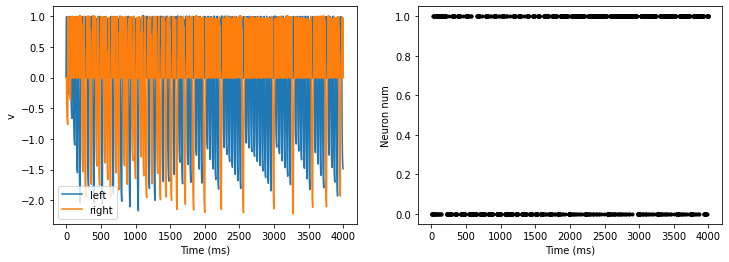

In [9]:
# For left
wCartPosition = -20  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = 1  # > 0 to low speed
wPoleAngle = -100  # < 0 to normal
wPoleVelocity = -10  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T
controller = NeuroController(w_sensor=w_sensor, I_tonic=1)

control_cartpole(controller, steps_count=200, sleep_time=0.00, stop_after_done=True)
plot_v_spikes(controller.v_mon, controller.spike_mon)

### Half-center oscillator

Добавим замедляющие синапсы в сеть

In [10]:
class HCOController(NeuroController):
    def __init__(self, tau=None, w_sensor=None, w_syn=-1, I_tonic=0):
        NeuroController.__init__(self, tau=tau, w_sensor=w_sensor, I_tonic=I_tonic)
        self.neurons.namespace.update({'w_syn': w_syn})
        S = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        S.connect(i=0, j=1)
        S.connect(i=1, j=0)
        self.net.add(S)

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0390     -0.0023     -0.0454      0.0168	0
1	     -0.0390     -0.1967     -0.0450      0.2948	0
2	     -0.0430     -0.3912     -0.0391      0.5730	1
3	     -0.0508     -0.1955     -0.0277      0.2682	0
4	     -0.0547     -0.3903     -0.0223      0.5521	1
5	     -0.0625     -0.1948     -0.0113      0.2524	1
6	     -0.0664      0.0004     -0.0062     -0.0438	0
7	     -0.0664     -0.1946     -0.0071      0.2469	1
8	     -0.0703      0.0006     -0.0022     -0.0480	0
9	     -0.0703     -0.1945     -0.0031      0.2440	1
10	     -0.0742      0.0007      0.0018     -0.0497	0
11	     -0.0742     -0.1944      0.0008      0.2436	1
12	     -0.0780      0.0007      0.0056     -0.0489	0
13	     -0.0780     -0.1945      0.0047      0.2456	1
14	     -0.0819      0.0005      0.0096     -0.0456	0
15	     -0.0819     -0.1947      0.0087      0.2501	1
16	     -0.0858      0.0003      0.0137     -0.0398	0
17	     -0.0858     -0.1951 

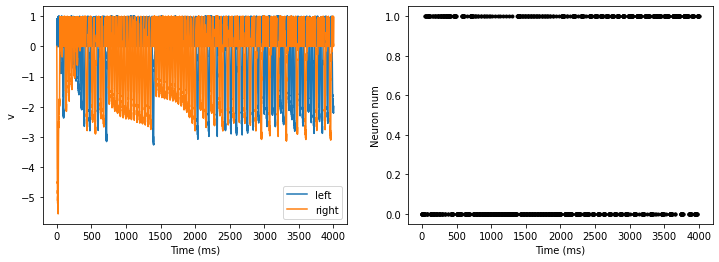

In [11]:
# For left
wCartPosition = -20  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = 1  # > 0 to low speed
wPoleAngle = -100  # < 0 to normal
wPoleVelocity = -10  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T
controller = HCOController(w_sensor=w_sensor, w_syn=-0.25, I_tonic=1)

control_cartpole(controller, steps_count=200, sleep_time=0.00, stop_after_done=True)
plot_v_spikes(controller.v_mon, controller.spike_mon)

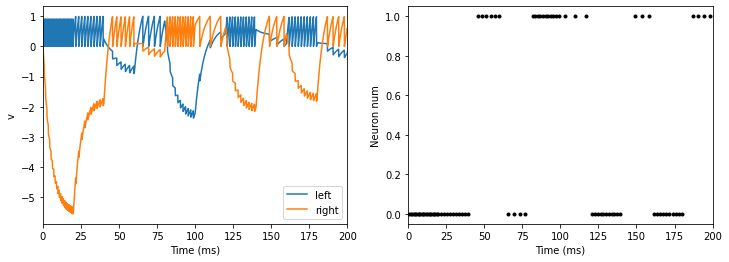

In [12]:
plot_v_spikes(controller.v_mon, controller.spike_mon, t_bounds=(0, 200))

### Parametric tuning

#### Funcs

In [13]:
from itertools import product

def get_bounds(bounds_dict, search_type='grid'):
    '''
    search_type: 'grid' (default), 'evo'
    '''
    if search_type == 'evo':
        return list(bounds_dict.values())
    elif search_type == 'grid':
        params = []
        for key in bounds_dict:
            params.append(np.linspace(bounds_dict[key][0], bounds_dict[key][1], 5))
        return set(product(*params))
    else:
        raise RuntimeError('Wrong search type')

In [14]:
def create_controller(x, ControllerClass=HCOController):
    b2.start_scope()
    I_tonic = x[0]
    w_syn = x[1]
    
    w = []
    for i in range(2, len(x)):
        w.append(x[i])
    w_sensor = np.array([np.array(w),
                         -np.array(w)]).T
    return ControllerClass(w_sensor=w_sensor, w_syn=w_syn, I_tonic=I_tonic)
    

def obj_fun(x, search_type='grid', controller_type='discr', num_run=1, save_file=None,
            print_log=False, print_max=True, last_max=[0], steps_count=1000, show=False, func_kwargs={}):
    '''
    controller_type: 'discr' (default), 'cont', 'cont_v2'
    '''
    total_R = 0
    if controller_type == 'discr':
        ControllerClass = HCOController
        controller_func = control_cartpole
    elif controller_type == 'cont':
        ControllerClass = ContHCOController
        controller_func = control_cont_cartpole
    elif controller_type == 'cont_v2':
        ControllerClass = ContHCOController_v2
        controller_func = control_cont_cartpole
    else:
        raise RuntimeError('Wrong controller_type')
    for _ in range(num_run):
        res = controller_func(create_controller(x, ControllerClass), steps_count=steps_count,
                                   show=show, print_log=False,
                                   **func_kwargs)
        total_R += res
        
    ret = total_R / num_run
    if print_log:
        print('\rparams:', str(x), 'reward:', ret, sep='\t')
    if save_file:
        with open(save_file, 'a') as f:
            print('params:', str(x), 'reward:', ret, sep='\t', file=f)
    if last_max[0] < ret:
        last_max[0] = ret
        if print_max:
            print('\rparams:', str(x), 'reward:', ret, 'NEW', sep='\t')
    return ret * (-1 if search_type == 'evo' else 1)

def clear_last_max():
    obj_fun.__defaults__[6][0] = 0

#### Tuning

In [15]:
bounds_dict = {
    'I_t': (0, 3),
    'w_syn': (-1, 0),
    'wCartPosition': (0, -100),
    'wCartVelocity': (0, 100),
    'wPoleAngle': (-100, 0),
    'wPoleVelocity': (0, -100),
}

##### GridSearch

In [16]:
# clear_last_max()
# params = get_bounds(bounds_dict)

# reward_idx = 0
# F = []
# best = None
# for x in tqdm(params):
#     F += [(obj_fun(x), x[0], x[1], x[2], x[3], x[4], x[5])]
# best = max(F, key=lambda x: x[reward_idx])
# print(f"\rBest solution: {best}")

##### Differential Evolution

In [18]:
# from scipy import optimize as opt

# clear_last_max()
# bounds = get_bounds(bounds_dict, 'evo')

# res = opt.differential_evolution(obj_fun, bounds, args=('evo', 'discr', 1), maxiter=25, popsize=10, disp=True)
# print(f"Best solution: Params={res.x}. Reward={res.fun}")
# res_hco = create_cont_controller(res.x)
# control_cont_cartpole(res_hco, show=True, print_log=False)
# plot_v_spikes(controller.v_mon, controller.spike_mon)

## Непрервыное управление

Теперь будем управлять импульсами от -1 до 1.

In [19]:
def control_cont_cartpole(*args, **kwargs):
    return control_cartpole(*args, **kwargs, make_env=CartPoleContEnv)

### RandomContController

In [20]:
class RandomContController:
    def next_action(self, observation, *args, **kwargs):
        return np.random.random() * 2 - 1

In [21]:
control_cont_cartpole(RandomContController())

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0284      0.0460      0.0137     -0.0473	-0.717181686286916
1	     -0.0275     -0.0941      0.0127      0.1669	0.006407417427895412
2	     -0.0294     -0.0931      0.0161      0.1690	-0.8327168544240511
3	     -0.0312     -0.2558      0.0195      0.4178	0.982514809369855
4	     -0.0363     -0.0643      0.0278      0.1364	0.305985600726318
5	     -0.0376     -0.0050      0.0306      0.0557	-0.39092101968445836
6	     -0.0377     -0.0818      0.0317      0.1797	-0.3366035275729824
7	     -0.0394     -0.1479      0.0353      0.2881	-0.7019806625560279
8	     -0.0423     -0.2853      0.0410      0.5046	-0.8106776348645093
9	     -0.0480     -0.4441      0.0511      0.7545	0.6294742609360924
10	     -0.0569     -0.3220      0.0662      0.5866	-0.8716708925309518
11	     -0.0633     -0.4929      0.0779      0.8619	-0.5432392510196475
12	     -0.0732     -0.5999      0.0952      1.0449	-0.07485066414608554
13	     -0.08

20.0

### ContNeuroController

In [22]:
import brian2 as b2
import numpy as np

class ContNeuroController(NeuroController):
    MAX_SPIKES = 200

    def next_action(self, observation, *args, **kwargs):
        self.neurons.inp = observation@self.w_sensor
        prev_spikes = np.array(self.spike_mon.count)
        self.net.run(self.T_step, namespace=self.neurons.namespace)
        new_spikes = self.spike_mon.count - prev_spikes
        left = new_spikes[self.LEFT]
        right = new_spikes[self.RIGHT]

        if max(left, right) > self.MAX_SPIKES:
            print(f'\n\n>>>>>>>> MAX SPIKES error: max is {max(left, right)}\n\n')
            if left > self.MAX_SPIKES:
                left = self.MAX_SPIKES
            if right > self.MAX_SPIKES:
                right = self.MAX_SPIKES

        if right > left:
            return right / self.MAX_SPIKES
        elif right < left:
            return - left / self.MAX_SPIKES
        else:
            return 0  #np.random.random() * 2 - 1

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	      0.0233     -0.0246     -0.0184     -0.0274	-0.165
1	      0.0228     -0.0566     -0.0190      0.0150	-0.165
2	      0.0216     -0.0885     -0.0187      0.0573	-0.17
3	      0.0199     -0.1214     -0.0175      0.1012	-0.14
4	      0.0175     -0.1485     -0.0155      0.1366	-0.125
5	      0.0145     -0.1726     -0.0128      0.1683	-0.09
6	      0.0110     -0.1900     -0.0094      0.1906	-0.055
7	      0.0072     -0.2006     -0.0056      0.2038	-0.015
8	      0.0032     -0.2034     -0.0015      0.2064	0.04
9	     -0.0009     -0.1956      0.0026      0.1942	0.075
10	     -0.0048     -0.1810      0.0065      0.1731	0.1
11	     -0.0084     -0.1616      0.0100      0.1459	0.125
12	     -0.0116     -0.1374      0.0129      0.1124	0.145
13	     -0.0144     -0.1093      0.0151      0.0740	0.165
14	     -0.0165     -0.0773      0.0166      0.0305	0.17
15	     -0.0181     -0.0443      0.0172     -0.0140	0.165
16	     -0.0190  

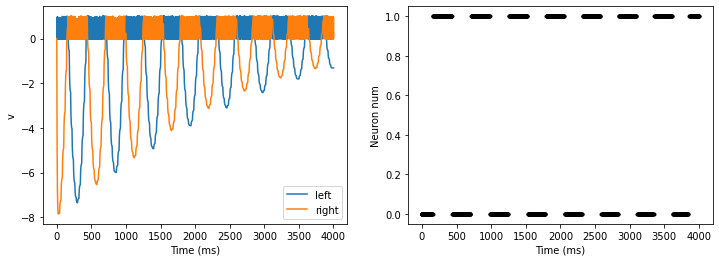

In [24]:
# For left
wCartPosition = -20  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = 1  # > 0 to low speed
wPoleAngle = -500  # < 0 to normal
wPoleVelocity = -10  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T
controller = ContNeuroController(w_sensor=w_sensor, I_tonic=1)

control_cont_cartpole(controller, steps_count=200, sleep_time=0.00, stop_after_done=True)
plot_v_spikes(controller.v_mon, controller.spike_mon)

### Continuous Half-center oscillator

In [27]:
class ContHCOController(ContNeuroController):
    def __init__(self, tau=None, w_sensor=None, w_syn=-1, I_tonic=0):
        NeuroController.__init__(self, tau=tau, w_sensor=w_sensor, I_tonic=I_tonic)
        self.neurons.namespace.update({'w_syn': w_syn})
        S = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        S.connect(i=0, j=1)
        S.connect(i=1, j=0)
        self.net.add(S)

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0132     -0.0064     -0.0435      0.0031	-0.33
1	     -0.0133     -0.0702     -0.0434      0.0859	-0.335
2	     -0.0147     -0.1349     -0.0417      0.1701	-0.335
3	     -0.0174     -0.1997     -0.0383      0.2549	-0.33
4	     -0.0214     -0.2635     -0.0332      0.3394	-0.25
5	     -0.0267     -0.3118     -0.0264      0.4020	-0.165
6	     -0.0329     -0.3436     -0.0184      0.4420	-0.115
7	     -0.0398     -0.3658     -0.0095      0.4698	-0.015
8	     -0.0471     -0.3686     -0.0001      0.4712	0.09
9	     -0.0545     -0.3510      0.0093      0.4448	0.165
10	     -0.0615     -0.3190      0.0182      0.3995	0.25
11	     -0.0679     -0.2705      0.0262      0.3320	0.25
12	     -0.0733     -0.2220      0.0328      0.2671	0.335
13	     -0.0777     -0.1572      0.0382      0.1795	0.335
14	     -0.0809     -0.0923      0.0417      0.0936	0.33
15	     -0.0827     -0.0286      0.0436      0.0102	0.335
16	     -0.0833  

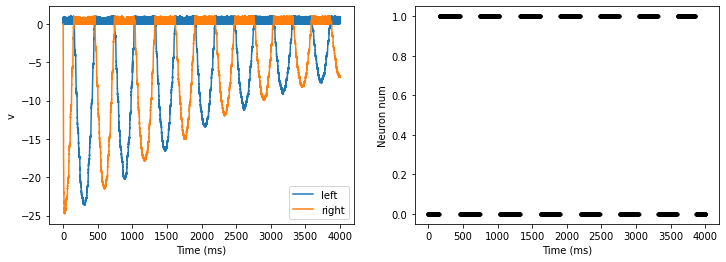

In [26]:
# For left
wCartPosition = -20  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = 1  # > 0 to low speed
wPoleAngle = -500  # < 0 to normal
wPoleVelocity = -10  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T
controller = ContHCOController(w_sensor=w_sensor, w_syn=-0.25, I_tonic=1)

control_cont_cartpole(controller, steps_count=200, sleep_time=0.00, stop_after_done=True)
plot_v_spikes(controller.v_mon, controller.spike_mon)

### Parametric tuning

#### Tuning

In [28]:
bounds_dict = {
    'I_t': (0, 3),
    'w_syn': (-1, 0),
    'wCartPosition': (0, -1000),
    'wCartVelocity': (0, 1000),
    'wPoleAngle': (-1000, 0),
    'wPoleVelocity': (0, -1000),
}

##### GridSearch

In [30]:
# clear_last_max()
# params = get_bounds(bounds_dict)

# reward_idx = 0
# F = []
# best = None
# for x in tqdm(params):
#     F += [(obj_fun(x, controller_type='cont'), x[0], x[1], x[2], x[3], x[4], x[5])]
# best = max(F, key=lambda x: x[reward_idx])
# print(f"\rBest solution: {best}")

##### Differential Evolution

In [32]:
# from scipy import optimize as opt

# clear_last_max()
# bounds = get_bounds(bounds_dict, 'evo')

# res = opt.differential_evolution(obj_fun, bounds, args=('evo', 'cont', 1), maxiter=25, popsize=10, disp=True)
# print(f"Best solution: Params={res.x}. Reward={res.fun}")
# res_hco = create_cont_controller(res.x)
# control_cont_cartpole(res_hco, show=True, print_log=False)
# plot_v_spikes(controller.v_mon, controller.spike_mon)

## Тележка в заданной точке

In [33]:
class ContHCOController_v2(ContHCOController):
    def next_action(self, obs, *args, **kwargs):
        if 'coord' not in kwargs:
            raise RuntimeError('No <coord> argument in kwargs')

        obs = np.append(obs, obs[0] - kwargs['coord'])
        w_cur = self.w_sensor
        if kwargs['coord'] < obs[0] and obs[0] < 0 or kwargs['coord'] > obs[0] and obs[0] > 0:
            w_cur[0, 0] = 0
            w_cur[0, 1] = 0

        self.neurons.inp = [0, 0] #obs @ w_cur
        for i in range(w_cur.shape[1]):
            for j in range(w_cur.shape[0]):
                self.neurons.inp[i] += np.sign(obs[j]) * np.exp(abs(obs[j])) * w_cur[j, i]
        prev_spikes = np.array(self.spike_mon.count)
        self.net.run(self.T_step, namespace=self.neurons.namespace)
        new_spikes = self.spike_mon.count - prev_spikes
        left = new_spikes[self.LEFT]
        right = new_spikes[self.RIGHT]

        if max(left, right) > self.MAX_SPIKES:
            print(f'\n\n>>>>>>>> MAX SPIKES error: max is {max(left, right)}\n\n')
            if left > self.MAX_SPIKES:
                left = self.MAX_SPIKES
            if right > self.MAX_SPIKES:
                right = self.MAX_SPIKES

        if right > left:
            return right / self.MAX_SPIKES
        elif right < left:
            return - left / self.MAX_SPIKES
        else:
            return 0  #np.random.random() * 2 - 1

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	      0.0338     -0.0405     -0.0290     -0.0188	-1.0
1	      0.0329     -0.2352     -0.0293      0.2646	0.835
2	      0.0282     -0.0718     -0.0240      0.0111	1.0
3	      0.0268      0.1236     -0.0238     -0.2891	-0.12
4	      0.0293      0.1006     -0.0296     -0.2615	-0.25
5	      0.0313      0.0522     -0.0348     -0.1977	-0.14
6	      0.0323      0.0254     -0.0388     -0.1677	-0.115
7	      0.0328      0.0035     -0.0421     -0.1463	-0.09
8	      0.0329     -0.0134     -0.0451     -0.1333	-1.0
9	      0.0326     -0.2079     -0.0477      0.1448	0.805
10	      0.0285     -0.0502     -0.0448     -0.1055	-0.83
11	      0.0275     -0.2114     -0.0470      0.1230	0.805
12	      0.0233     -0.0537     -0.0445     -0.1271	-0.835
13	      0.0222     -0.2160     -0.0470      0.1029	0.795
14	      0.0179     -0.0602     -0.0450     -0.1443	-0.84
15	      0.0167     -0.2235     -0.0479      0.0871	0.785
16	      0.0122     

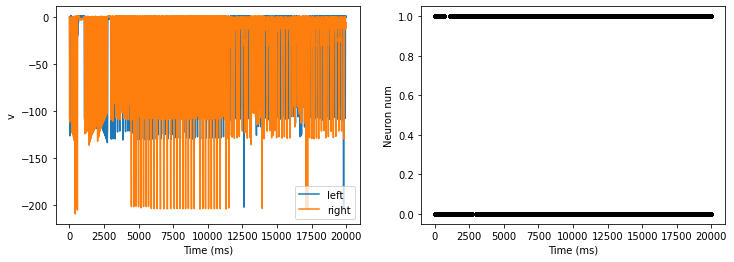

In [37]:
# For left
wCartPosition = -75  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = -55  # > 0 to low speed
wPoleAngle = -50  # < 0 to normal
wPoleVelocity = -100  # < 0 to normal
wCoord = -11

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity, wCoord],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity, -wCoord]]).T
controller = ContHCOController_v2(w_sensor=w_sensor, w_syn=-0.25, I_tonic=1.15)

control_cont_cartpole(controller, steps_count=1000, sleep_time=0, 
                      stop_after_done=False, coord=-1)
plot_v_spikes(controller.v_mon, controller.spike_mon)

### Parametric tuning

In [38]:
bounds_dict = {
    'I_t': (0, 3),
    'w_syn': (-1, 0),
    'wCartPosition': (-100, 100),
    'wCartVelocity': (-100, 100),
    'wPoleAngle': (-100, 100),
    'wPoleVelocity': (-100, 100),
    'wCoord': (-100, 100)
}

In [39]:
def search_grid(func, bounds, x0=None, func_args=(), func_kwargs={}):
    bounds = bounds[:]
    x0 = x0 or [0 for q in bounds]
    x_best = x0
    best_res = func(tuple(x_best), *func_args, **func_kwargs)
    searching = True
    adding = 50
    first = True
    while searching:
        try:
            searching = False
            for i, bound in enumerate(bounds):
                if i > 1:
                    first = False
                if first:
                    continue
                vals = np.linspace(bound[0], bound[1], 10)
                if i > 1 and adding > 5:
                    vals = vals.astype(int)
                x_cur = x_best[:]
                for j, val in enumerate(vals):
                    print(f'\rIter {j}', end='')
                    x_cur[i] = val
                    if x_cur == x_best:
                        continue
                    res = func(tuple(x_cur), *func_args, **func_kwargs)
                    if res < best_res:
                        best_res = res
                        x_best = x_cur[:]
                        searching = True
                bound_len = abs(bound[0] - bound[1]) / 2
                bounds[i] = (x_best[i] - min(bound_len, adding), x_best[i] + min(bound_len, adding))
            print('\n\nNEW BOUNDS:', bounds, 'adding:', adding, end='\n\n')
            if searching == False:
                if adding == 0:
                    break
                adding //= 2
                searching = True
        except KeyboardInterrupt:
            searching = False
    return best_res, x_best

In [109]:
clear_last_max()
bounds = get_bounds(bounds_dict, 'evo')

res = search_grid(obj_fun, bounds, x0=[1.15, -0.55, -75, -55, -50, -100, -11],
                  func_kwargs={'search_type': 'evo', 'controller_type':'cont_v2',
                               'steps_count': 200, 'show': False, 'print_log': True,
                               'save_file': 'cont_v2.txt', 'num_run': 3,
                               'func_kwargs': {'coord': 1, 'coord_penalty': True}})
res

params:	(1.5, -0.5, -75, -50, -50, -100, -10)	reward:	187.28654469348757
params:	(1.5, -0.5, -75, -50, -50, -100, -10)	reward:	187.28654469348757	NEW
params:	(1.5, -0.5, -100, -50, -50, -100, -10)	reward:	181.57110653981906
params:	(1.5, -0.5, -77, -50, -50, -100, -10)	reward:	183.54443596032988
params:	(1.5, -0.5, -55, -50, -50, -100, -10)	reward:	184.13879725349094
params:	(1.5, -0.5, -33, -50, -50, -100, -10)	reward:	181.95351003878613
params:	(1.5, -0.5, -11, -50, -50, -100, -10)	reward:	184.6254886593604
params:	(1.5, -0.5, 11, -50, -50, -100, -10)	reward:	181.17050264245532
params:	(1.5, -0.5, 33, -50, -50, -100, -10)	reward:	179.23566443359232
params:	(1.5, -0.5, 55, -50, -50, -100, -10)	reward:	179.15130754068284
params:	(1.5, -0.5, 77, -50, -50, -100, -10)	reward:	180.95805932800866
params:	(1.5, -0.5, 100, -50, -50, -100, -10)	reward:	181.7674789760208
params:	(1.5, -0.5, -75, -100, -50, -100, -10)	reward:	49.06502089114647
params:	(1.5, -0.5, -75, -77, -50, -100, -10)	reward

In [110]:
res

(-197.36117375822013,
 [1.1666666666666665, -0.2777777777777779, -75, -55, -50, -100, -11])